# 0.0 IMPORTS

In [41]:
import sklearn
import random
import pandas  as pd
import numpy   as np
import seaborn as sns


from sklearn                 import model_selection as ms
from sklearn                 import metrics         as m
from sklearn                 import preprocessing   as pp
from scikitplot              import metrics         as mt
from keras                   import models          as ml
from keras                   import layers          as l
from scipy                   import stats           as ss
from matplotlib              import pyplot          as plt
from IPython.display         import Image
from IPython.core.display    import HTML
from sklearn.model_selection import train_test_split


## 0.1 Helper Functions


In [2]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Djalma.junior\Anaconda3\envs\airbnb-new-user-dest\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


##  0.2 Load dataset

In [3]:
df_raw = pd.read_csv('C:/Users/Djalma.junior/DS/Airbnb/datasets/train.csv')

#  1.0 DESCRICAO DOS DADOS


In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
df1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

## 1.2. Data Dimensions

In [6]:
print ('Number of columns {}'.format(df1.shape[1]))
print ('Number of rows {}'.format(df1.shape[0]))

Number of columns 16
Number of rows 213451


## 1.3. Data Types

In [7]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.4. Check NA

In [8]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [9]:
df1 = df1.dropna()
df1.shape

(68171, 16)

## 1.5 Change NA

In [10]:
df1.sample().T

,26728
id,2w2vx2z19g
date_account_created,2012-06-06
timestamp_first_active,20120606060051
date_first_booking,2012-06-06
gender,-unknown-
age,33.0
signup_method,basic
signup_flow,0
language,en
affiliate_channel,direct


In [11]:
#date_account_created  
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active    
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format = ('%Y%m%d%H%M%S'))

#date_first_booking  
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

#age
df1['age'] = df1['age'].astype(np.int64)


## 1.6 Check Balanced Data

In [12]:
df1['country_destination'].value_counts(normalize=True)

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

#  2.0 FILTRAGEM DE VARIÁVEIS


In [13]:
df2=df1.copy()

## 2.1 Filtering Row

## 2.2 Columns Selection

# 3.0 DATA PREPARATION

In [14]:
df3 = df2.copy()
df3.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,2010-01-03 19:19:05,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US


In [15]:
# dummy variable
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )

In [16]:
df3.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,2010-01-03 19:19:05,2010-01-13,FEMALE,47,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US


In [17]:
# join id and country destination
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy], axis=1 )

In [18]:
df3.head()

,id,country_destination,date_account_created,timestamp_first_active,date_first_booking,age,signup_flow,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,signup_method_facebook,signup_method_google,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hu,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CoolNovo,first_browser_Firefox,first_browser_IE,first_browser_IE Mobile,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Opera,first_browser_Opera Mini,first_browser_Pale Moon,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_Yandex.Browser
2,4ft3gnwmtx,US,2010-09-28,2009-06-09 23:12:47,2010-08-02,56,3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,other,2011-12-05,2009-10-31 06:01:29,2012-09-08,42,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,US,2010-09-14,2009-12-08 06:11:05,2010-02-18,41,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,lsw9q7uk0j,US,2010-01-02,2010-01-02 01:25:58,2010-01-05,46,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,0d01nltbrs,US,2010-01-03,2010-01-03 19:19:05,2010-01-13,47,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

# 4.0 FEATURE SELECTION


In [19]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates
df4 = df3.drop( cols_drop, axis=1 )

In [20]:
df4.sample().T

,60711
id,jlzhkmkf45
country_destination,US
age,36
signup_flow,0
gender_-unknown-,1
gender_FEMALE,0
gender_MALE,0
gender_OTHER,0
signup_method_basic,1
signup_method_facebook,0


In [21]:
# split dataset into training  and test data
X = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()


X_train, X_validation, y_train, y_validation = train_test_split( X, y, test_size=0.20, random_state=32 )

df5 = pd.concat( [X_train, y_train], axis=1 )

In [22]:
x_train = X_train.drop( 'id', axis=1 )
x_validation = X_validation.drop( 'id', axis=1 )

# 5.0 Machine Learning Model - Neural Network MLP



In [23]:
df5 = df4.copy()


In [24]:
x_train.shape[1]

112

In [25]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [26]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128, input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 11, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.3522 - accuracy: 0.7017
Epoch 2/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2572 - accuracy: 0.7080
Epoch 3/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2456 - accuracy: 0.7079
Epoch 4/100
1705/1705 [==============================] - 2s 985us/step - loss: 1.2085 - accuracy: 0.70820s - loss: 1.2062 - accuracy: 0.70
Epoch 5/100
1705/1705 [==============================] - 2s 965us/step - loss: 1.1916 - accuracy: 0.7084
Epoch 6/100
1705/1705 [==============================] - 2s 971us/step - loss: 1.1804 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 2s 973us/step - loss: 1.1672 - accuracy: 0.7086
Epoch 8/100
1705/1705 [==============================] - 2s 970us/step - loss: 1.1582 - accuracy: 0.7086
Epoch 9/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1504 - accuracy: 0.7087: 0s - loss: 1.1510 - accuracy

1705/1705 [==============================] - 2s 983us/step - loss: 1.1005 - accuracy: 0.71170s - loss: 1.1055 - accuracy: 0.70 - ETA: 0s - l
Epoch 73/100
1705/1705 [==============================] - 2s 969us/step - loss: 1.1007 - accuracy: 0.71140s - loss: 1.1002 - accura
Epoch 74/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1006 - accuracy: 0.7117
Epoch 75/100
1705/1705 [==============================] - 2s 977us/step - loss: 1.0999 - accuracy: 0.71180s - loss: 1.1002 - accura
Epoch 76/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1001 - accuracy: 0.7115
Epoch 77/100
1705/1705 [==============================] - 2s 967us/step - loss: 1.0997 - accuracy: 0.71190s - loss: 1.1058 - 
Epoch 78/100
1705/1705 [==============================] - 2s 968us/step - loss: 1.0995 - accuracy: 0.7116
Epoch 79/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0996 - accuracy: 0.7115
Epoch 80/100
1705/1705 [===========================

## 5.1 Baseline Model

In [34]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_validation.shape[0]
country_destination_weights = df1['country_destination'].value_counts( normalize=True ).sort_index().tolist()

yhat_random = random.choices( population=country_destination_list,  
                              weights=country_destination_weights,
                              k=k_num )
len(yhat_random)

13635

Accuracy: 0.5138980564723139
Balanced Accuracy:0.08892244259115151
Kappa Score: -0.0076505047039785445
              precision    recall  f1-score   support

          AU       0.01      0.01      0.01       101
          CA       0.01      0.01      0.01       214
          DE       0.01      0.01      0.01       170
          ES       0.02      0.02      0.02       345
          FR       0.06      0.06      0.06       710
          GB       0.03      0.03      0.03       344
          IT       0.03      0.02      0.02       423
          NL       0.01      0.01      0.01       128
          PT       0.00      0.00      0.00        36
          US       0.70      0.70      0.70      9624
       other       0.11      0.11      0.11      1540

    accuracy                           0.51     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.51      0.51      0.51     13635



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

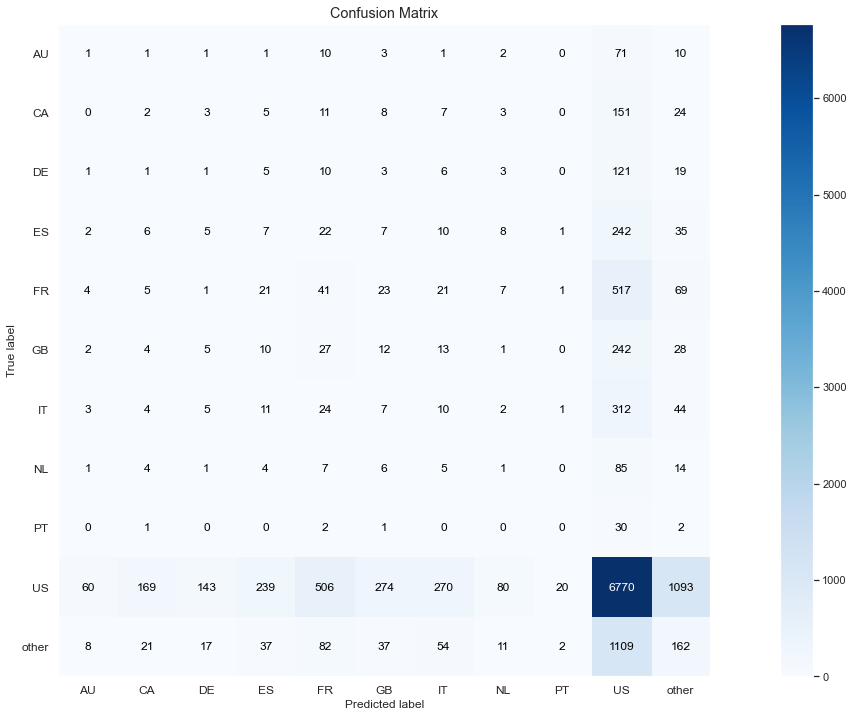

In [36]:
acc_random = m.accuracy_score( y_validation, yhat_random )
print( 'Accuracy: {}'.format( acc_random ) )

# Balanced Accuray
balanced_acc_random = m.balanced_accuracy_score( y_validation, yhat_random )
print( 'Balanced Accuracy:{}'.format( balanced_acc_random ) )

# Kappa Metrics
kappa_random = m.cohen_kappa_score( y_validation, yhat_random )
print( 'Kappa Score: {}'.format( kappa_random ) )

# Classification report
print( m.classification_report( y_validation, yhat_random ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_validation, yhat_random, normalize=False)


## 5.2 NN PERFORMANCE


In [37]:
# PREDICTION 
pred_nn = model.predict(x_validation)

# INVERT PRED
yhat_nn=ohe.inverse_transform(pred_nn)

# PREDICTION PREPARE
y_test_nn = y_validation.to_numpy()
yhat_nn = yhat_nn.reshape (1, -1)[0]

Accuracy: 0.7036303630363037
Balanced Accuracy: 0.09164687968714001
Kappa Score: 0.003176972239403497


C:\Users\Djalma.junior\Anaconda3\envs\airbnb-new-user-dest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Djalma.junior\Anaconda3\envs\airbnb-new-user-dest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.25      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.27      0.01      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.11      0.09      0.08     13635
weighted avg       0.53      0.70      0.58     13635



C:\Users\Djalma.junior\Anaconda3\envs\airbnb-new-user-dest\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

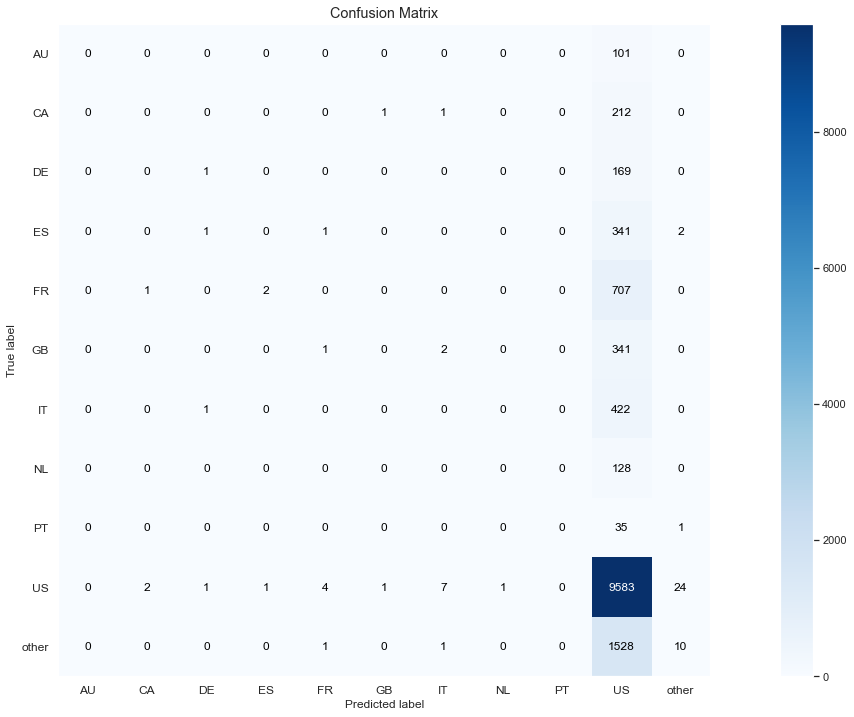

In [38]:
# accuracy 
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print ('Accuracy: {}'.format(acc_nn))

# balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print( 'Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print( 'Kappa Score: {}'.format(kappa_nn))

# classification report
print(m.classification_report(y_test_nn, yhat_nn))

# confusion matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize = False)


## 5.2.1 NN PERFORMANCE CROSS VALIDATION


In [47]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = m.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [49]:
print( 'Avg Balanced Accuracy: {} +/- {}'.format( np.mean( balanced_acc_list ), np.std( balanced_acc_list ) )
print( 'Avg Kappa: {} +/- {}'.format( np.mean( kappa_acc_list ), np.std( kappa_acc_list ) )                                        

SyntaxError: invalid syntax (<ipython-input-49-55215313d6e6>, line 2)